<a href="https://colab.research.google.com/github/x23425237/DeepLearning_GenAI/blob/main/JMP_RNN_Finial_PredictTomorrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

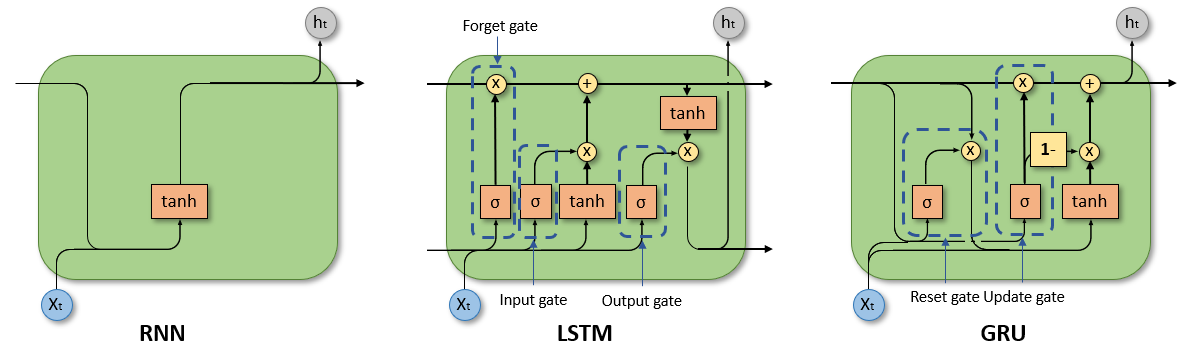

JP-Morgan - Daily Stock price Analysis and LSTM
1. Fetch data through api
2.scale the features and target - minmax scalar
3.perform data pre-processing
4.split data train and test 80/20, 60/40
5.RNN- Vanilla
6.Bidirectional RNN
7.Record test and validation loss
8.Record model accuracy metrics- MAE,MSE,RMSE

In [ ]:
import numpy as np
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,RepeatVector,TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
import tensorflow as tf
from tensorflow.keras import layers

set_seed(455)
np.random.seed(455)

In [ ]:
# get data from api  Alpha Vantage Stock API
# G2DBRN7KCM4QHZWY
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=JPM&interval=5min&outputsize=full&apikey=G2DBRN7KCM4QHZWY'
r = requests.get(url)
data = r.json()

print(data)


In [ ]:
time_series = data.get('Time Series (5min)', {})
df=pd.DataFrame.from_dict(time_series,orient='index')

df['1. open'] = df['1. open'].astype(float)
df['2. high'] = df['2. high'].astype(float)
df['3. low'] = df['3. low'].astype(float)
df['4. close'] = df['4. close'].astype(float)
df['5. volume'] = df['5. volume'].astype(int)


In [ ]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
display(df)

,1. open,2. high,3. low,4. close,5. volume
2025-04-07 19:55:00,216.5800,217.0300,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.7000,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.7000,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.9500,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.0000,216.7001,216.9100,517
...,...,...,...,...,...
2025-03-10 04:20:00,238.6312,238.6312,238.4624,238.6213,38
2025-03-10 04:15:00,238.8796,238.8796,238.5915,238.5915,94
2025-03-10 04:10:00,238.8796,238.8796,238.8796,238.8796,1
2025-03-10 04:05:00,238.8796,238.8796,238.6114,238.6114,2


In [ ]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
# rename the columns
dict = {'1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
        }
df.rename(columns=dict,
          inplace=True)

display(df)

,Open,High,Low,Close,Volume
2025-04-07 19:55:00,216.5800,217.0300,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.7000,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.7000,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.9500,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.0000,216.7001,216.9100,517
...,...,...,...,...,...
2025-03-10 04:20:00,238.6312,238.6312,238.4624,238.6213,38
2025-03-10 04:15:00,238.8796,238.8796,238.5915,238.5915,94
2025-03-10 04:10:00,238.8796,238.8796,238.8796,238.8796,1
2025-03-10 04:05:00,238.8796,238.8796,238.6114,238.6114,2


In [ ]:
#re-set index to rename column
reset_index=df.reset_index()
reset_index.rename(columns={'index': 'DateTime'}, inplace=True)

# change dateime object to datetime
reset_index['DateTime'] = pd.to_datetime(reset_index['DateTime'])

reset_index.head()

,DateTime,Open,High,Low,Close,Volume
0,2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
1,2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2,2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
3,2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
4,2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
# RNN/vanilla RNN

# Import necessary libraries
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

In [ ]:
# Extract the relevant features (here we assume we're using 'Close' to predict 'Close')
features = reset_index[['Open', 'High', 'Low', 'Volume']].values
target = reset_index['Close'].values

In [ ]:
# Normalize the feature data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)

In [ ]:
# Normalize the target variable (Closing Price)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))


In [ ]:
# Prepare the data for time-series prediction (X = features, y = target)
X = []
y = []

# we are telling the model to look back 60 datapoints to predict next day's closing price.
# values tested for 3 and 60

sequence_length = 60 #3 # Number of previous time steps to consider for prediction

for i in range(sequence_length, len(features_scaled)):
    X.append(features_scaled[i-sequence_length:i])  # Take the last `sequence_length` data points
    y.append(target_scaled[i])  # The corresponding closing price

In [ ]:
X = np.array(X) # convert list to numpy array
y = np.array(y)

# Split the data into training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Simple RNN Model/Vanilla RNN
# 50 is the number of neurons, return sequence returns full sequence for each input to next layer
# for input we are passking 60 features and all four variables open, high,low and volume to input layer each time.
# Build the Simple RNN Model/Vanilla RNN
#model = Sequential()

#model.add(SimpleRNN(128, activation='relu'))
#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
#model.add(SimpleRNN(units=50))
#model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0

In [ ]:
# Simple RNN Model/Vanilla RNN
# 50 is the number of neurons, return sequence returns full sequence for each input to next layer
# for input we are passking 60 features and all four variables open, high,low and volume to input layer each time.
# Build the Simple RNN Model/Vanilla RNN
#model = Sequential()

#model.add(SimpleRNN(128, activation='relu'))
#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
#model.add(SimpleRNN(units=50, return_sequences=True))
#model.add(SimpleRNN(units=50))
#model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0

In [ ]:
# activation="tanh",activation="sigmoid"
#model = Sequential()

#model.add(SimpleRNN(130, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(SimpleRNN(110, activation="tanh", return_sequences=True))
#model.add(SimpleRNN(130, activation="tanh", return_sequences=True))
#model.add(SimpleRNN(100, return_sequences=True))
#model.add(SimpleRNN(40, dropout=0.2, activation="tanh"))

In [ ]:
#Bidirectional
model = Sequential()


model.add(Bidirectional(SimpleRNN(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(SimpleRNN(units=50, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=50)))
model.add(Dropout(0.2))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(X_train.shape)
print(y_train.shape) # 3241 in y train which is a good porting of training
print(X_test.shape)
print(y_test.shape)# 811 points in y-test

(3093, 60, 4)
(3093, 1)
(774, 60, 4)
(774, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Add a Dense layer to get the output prediction
model.add(Dense(units=1))



# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.001),  metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [ ]:
#Print model summary
model.summary()

# model output sequence of 60 , 100 features

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 100)             │           5,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 60, 100)             │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,801 (139.85 KB)

 Trainable params: 35,801 (139.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history=model.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test))

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - loss: 0.4429 - val_loss: 0.1873
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.1911 - val_loss: 0.0388
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.1345 - val_loss: 0.0588
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0945 - val_loss: 0.0686
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0803 - val_loss: 0.0260
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0779 - val_loss: 0.0175
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0609 - val_loss: 0.0269
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0567 - val_loss: 0.0562
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0496 - val_loss: 0.0382
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0480 - val_loss: 0.0277
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0424 - val_loss: 0.0245
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


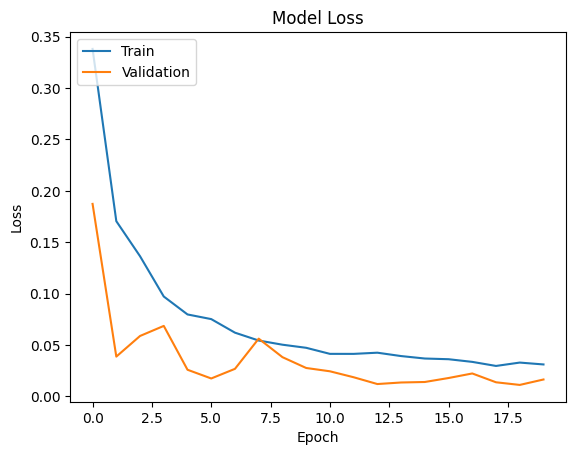

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Mean Absolute Error: 0.016503581504480936


In [ ]:
# Evaluate the performance of your LSTM model:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.016503581504480936
Mean Squared Error (MSE): 0.001019030564836847
Root Mean Squared Error (RMSE): 0.03192225814125384


In [ ]:
# Invert scaling for the actual and predicted closing prices
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

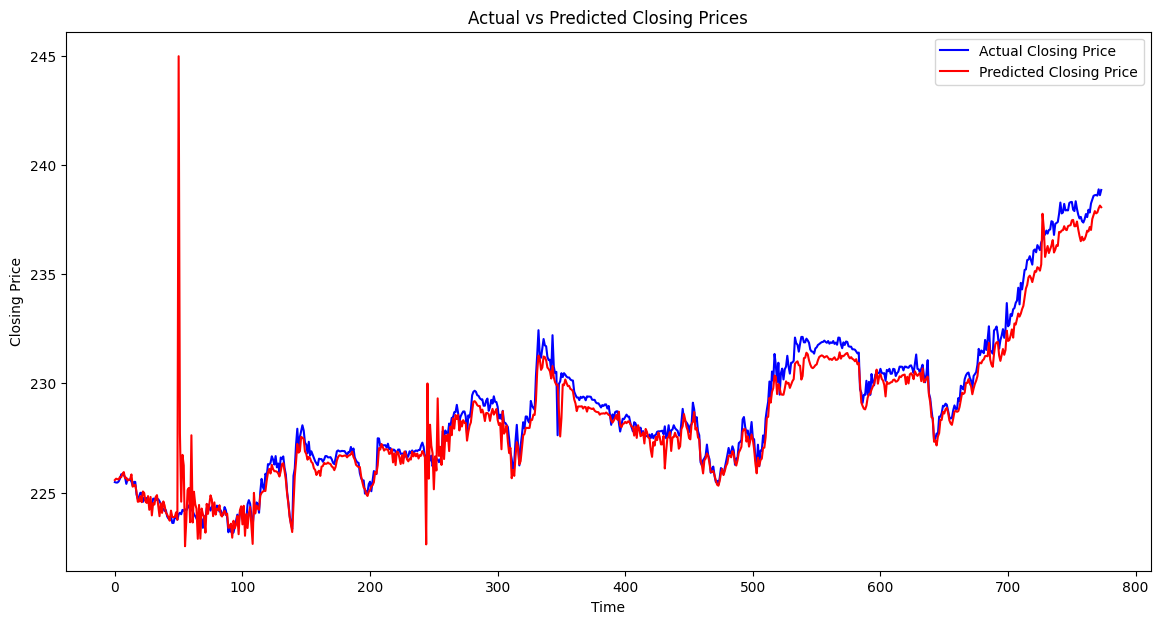

In [ ]:
# Plotting Actual vs Predicted closing prices
plt.figure(figsize=(14, 7))

# Plot actual closing prices
plt.plot(y_test_rescaled, color='blue', label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(y_pred_rescaled, color='red', label='Predicted Closing Price')

plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
y_pred_rescaled

array([[225.5731 ],
       [225.63593],
       [225.61478],
       [225.60454],
       [225.71587],
       [225.70229],
       [225.85797],
       [225.9382 ],
       [225.65482],
       [225.68199],
       [225.55725],
       [225.575  ],
       [225.61842],
       [225.83247],
       [225.27118],
       [225.32538],
       [225.35246],
       [225.01753],
       [224.57887],
       [224.59402],
       [224.836  ],
       [224.56303],
       [225.0496 ],
       [224.98235],
       [224.59496],
       [224.52585],
       [224.83945],
       [224.21292],
       [224.80035],
       [223.956  ],
       [224.5165 ],
       [224.45073],
       [224.7975 ],
       [224.88301],
       [224.37961],
       [223.91995],
       [224.50877],
       [224.07161],
       [224.59584],
       [224.40862],
       [224.08495],
       [223.99146],
       [223.8638 ],
       [223.71295],
       [224.1743 ],
       [223.88815],
       [223.87378],
       [223.88727],
       [224.09654],
       [223.75558],


In [ ]:
reset_index.iloc[-1]

,3926
DateTime,2025-03-10 04:00:00
Open,240.022
High,240.2803
Low,238.6809
Close,238.8498
Volume,449


In [ ]:
# Select the last `time_step` rows for the four features ('Open', 'High', 'Low', 'Volume')
X_input = reset_index.iloc[-sequence_length:][['Open', 'High', 'Low', 'Volume']].values

# Scaling the data using the scaler (like MinMaxScaler or StandardScaler)
X_input = scaler.fit_transform(X_input)

# Reshape the data into a 3D array (1 sample, `time_step` time steps, 4 features)
X_input = np.reshape(X_input, (1, sequence_length, 4))

# Print the shape of `X_input`
print("Shape of X_input :", X_input.shape)

# Show the transformed `X_input`
X_input

Shape of X_input : (1, 60, 4)


array([[[-8.75842484e-01, -1.00000000e+00, -1.00000000e+00,
         -2.20901218e-01],
        [-8.53275275e-01, -8.66326843e-01, -7.56310680e-01,
         -8.59092911e-01],
        [-7.32942067e-01, -8.66326843e-01, -8.12161472e-01,
         -8.81109643e-01],
        [-9.05944718e-01, -8.30726883e-01, -7.61420542e-01,
         -2.57595773e-01],
        [-1.00000000e+00, -8.73463146e-01, -7.66479305e-01,
          6.51548510e-01],
        [-7.55509277e-01, -8.29870527e-01, -8.21614716e-01,
          8.46469984e-01],
        [-7.66792881e-01, -7.32612907e-01, -5.63413388e-01,
          1.00000000e+00],
        [-7.74290042e-01, -7.97451320e-01, -4.66990291e-01,
         -7.28753853e-01],
        [-7.47974252e-01, -6.88082373e-01, -4.72049055e-01,
          7.41230001e-02],
        [-6.99091253e-01, -7.48842899e-01, -4.71997956e-01,
         -4.42536328e-01],
        [-7.55509277e-01, -7.77184219e-01, -5.58354624e-01,
         -3.63276090e-01],
        [-5.29799318e-01, -6.27321847e-01, 

In [ ]:
simple_RNN_prediction = model.predict(X_input)
y_pred_rescaled_simplernn = target_scaler.inverse_transform(simple_RNN_prediction)

print(y_pred_rescaled_simplernn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[249.7841]]
